In [6]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline

from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD,SVDpp
from surprise import KNNBasic
from surprise import KNNWithMeans

#setting up for customized printing
from IPython.display import Markdown, display
from IPython.display import HTML
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
#function to display dataframes side by side    
from IPython.display import display_html
def display_side_by_side(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-left:50px !important;margin-right: 40px !important"'),raw=True)

## Loading the dataset

In [7]:
electronics_dataframe = pd.read_csv("data/ratings_Electronics.csv",
                             names=['userId', 'productId','Rating','timestamp'])

In [8]:
electronics_dataframe.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


## Attributes and Information
1. userId : Every user identified with a unique id
2. productId : Every product identified with a unique id
3. Rating : Rating of the corresponding product by the corresponding user
4. timestamp : Time of the rating

## Perform EDA on Data

#### a. Drop 'timestamp' attribute

In [9]:
electronics_dataframe.drop('timestamp', axis=1, inplace=True)

#### b. Create subset of the original dataset
###### Filtering the users who has given 50 or more number of ratings

In [10]:
electronics_groupby_users_Ratings = electronics_dataframe.groupby('userId')['Rating']
electronics_groupby_users_Ratings = pd.DataFrame(electronics_groupby_users_Ratings.count())

In [11]:
user_list_min50_ratings = electronics_groupby_users_Ratings[electronics_groupby_users_Ratings['Rating'] >= 50].index
electronics_dataframe =  electronics_dataframe[electronics_dataframe['userId'].isin(user_list_min50_ratings)]

#### c. Shape of the data

In [12]:
print('The total number of rows :', electronics_dataframe.shape[0])
print('The total number of columns :', electronics_dataframe.shape[1])

The total number of rows : 125871
The total number of columns : 3


#### d. Data type of each attribute

In [13]:
electronics_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125871 non-null  object 
 1   productId  125871 non-null  object 
 2   Rating     125871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


#### e. Checking the presence of missing values

In [14]:
display(electronics_dataframe.isna().sum().sort_values())
print('===================')
printmd('**CONCLUSION**: As seen from the data above, we conclude there are **"No Missing"** values in the data', color="blue")

userId       0
productId    0
Rating       0
dtype: int64

<span style='color:blue'>**CONCLUSION**: As seen from the data above, we conclude there are **"No Missing"** values in the data</span>

### f. 5 point summary of numerical attributes

In [15]:
display(electronics_dataframe[['Rating']].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Rating,125871.0,4.261339,1.062144,1.0,4.0,5.0,5.0,5.0


### g. Unique Users and Products Count

In [16]:
print('Total unique users in the dataset', electronics_dataframe['userId'].nunique())
print('Total unique products in the dataset', electronics_dataframe['productId'].nunique())

Total unique users in the dataset 1540
Total unique products in the dataset 48190


## Data Analysis and Visualization

#### a. Rating Distribution

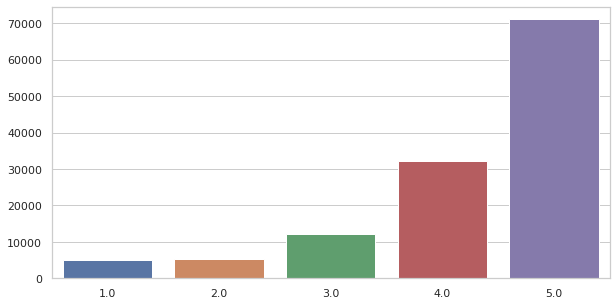

In [17]:
plt.figure(figsize=(10,5))
ratings = electronics_dataframe['Rating'].value_counts()
sns.barplot(x=ratings.index, y=ratings.values)
plt.show()

#### Observations
1. Many users have rated 5 as it is shown with the huge spike
2. This is followed by rating 4 which also has high number
3. Ratings 1, 2, 3 are comparatively less.

In [19]:
def distplot(figRows,figCols,xSize, ySize, data, features, colors, kde=True, bins=None):
    f, axes = plt.subplots(figRows, figCols, figsize=(xSize, ySize))
    
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(figRows, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1) :
                axesplt = axes
            elif (figRows == 1 and figCols > 1) :
                axesplt = axes[col]
            elif (figRows > 1 and figCols == 1) :
                axesplt = axes[row]
            else:
                axesplt = axes[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)

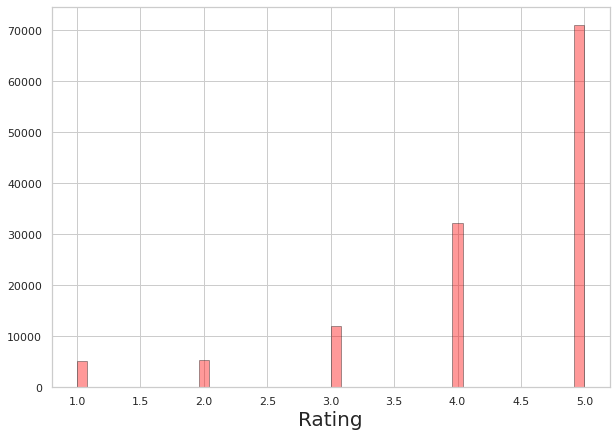

In [20]:
distplot(1, 1, 10, 7, data=electronics_dataframe, features=['Rating'], colors=['red'], kde=False)


#### Observations
1. Many users have rated 5 as it is shown with the huge spike with a value of more than 70k records.
2. This is followed by rating 4 which also has high number with a value of mroe than 30k records.
3. More than 10k users have rated 3.
4. Rating 1 and 2 have been rated below 10k records.

#### b. Top Rating Count Distribution grouped by Products

In [21]:
electronics_groupby_products_Ratings = electronics_dataframe.groupby('productId')['Rating']
electronics_groupby_products_Ratings.count().clip(upper=30).unique()


array([ 1,  2,  4,  6,  5,  8,  3,  7, 12,  9, 17, 16, 10, 13, 21, 19, 11,
       18, 14, 30, 15, 28, 23, 29, 24, 22, 25, 20, 26, 27])

In [22]:
ratings_products = pd.DataFrame(electronics_groupby_products_Ratings.count().clip(upper=30))
ratings_products.rename(columns={"Rating": "Rating_Count"}, inplace=True)

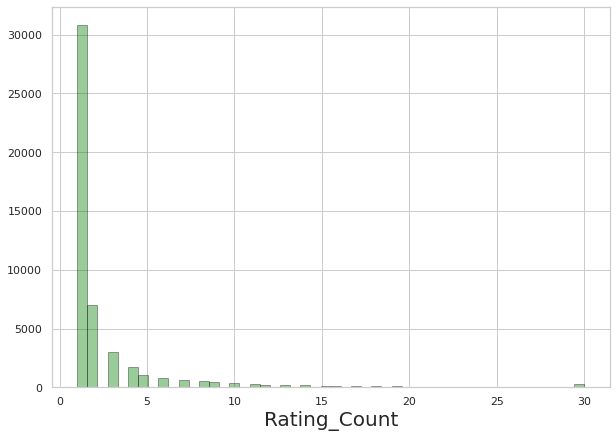

In [23]:
distplot(1, 1, 10, 7, data=ratings_products, features=['Rating_Count'], colors=['green'], kde=False)

#### Observations
This is a ratings count distribution grouped by all the Products. For the plot perspective, I have clipped the upper limit to 30 which means any value above 30 will be set to it.

As it can been seen from the plot, there are many products which were rated only once i.e. only one user have rated. And then the count decreases.

#### c. Top Rating Count Distribution grouped by Users

In [24]:
electronics_groupby_users_Ratings = electronics_dataframe.groupby('userId')['Rating']
electronics_groupby_users_Ratings.count().clip(lower=50).unique()


array([116, 132,  68,  71,  65,  57,  96,  80, 107, 123,  77, 130,  52,
        89, 112,  67,  86,  66,  75, 205,  58,  50, 216,  92,  54,  64,
        51, 252,  72,  81,  74,  53,  62,  70, 104, 102,  60,  63, 157,
        99,  56,  55,  61, 261, 151,  94,  78, 119,  83,  73, 144, 177,
       149, 106,  82,  69, 108, 196,  76, 221, 197, 200, 155, 208, 207,
       181, 160, 213,  59, 103,  85,  98, 145, 218,  84, 101,  91, 100,
        88, 114,  79,  93, 131, 142, 380,  90,  95, 126, 110, 105,  97,
       167, 227, 128, 127, 247, 129, 220, 121,  87, 202, 109, 156, 111,
       162, 240, 125, 137, 150, 292, 270, 115, 226, 296, 311, 176, 170,
       122, 117, 159, 277, 238, 120, 253, 138, 171, 136, 314, 282, 236,
       257, 204, 146, 124, 174, 279, 118, 199, 209, 498, 266, 143, 169,
       134, 173, 147, 182, 163, 180, 153, 225, 520, 406, 431, 193, 139,
       501, 239, 244, 192, 141, 198, 212, 308, 168, 189])

In [25]:
rating_users = pd.DataFrame(electronics_groupby_users_Ratings.count().clip(lower=50, upper=300))
rating_users.rename(columns={"Rating": "Rating_Count"}, inplace=True)

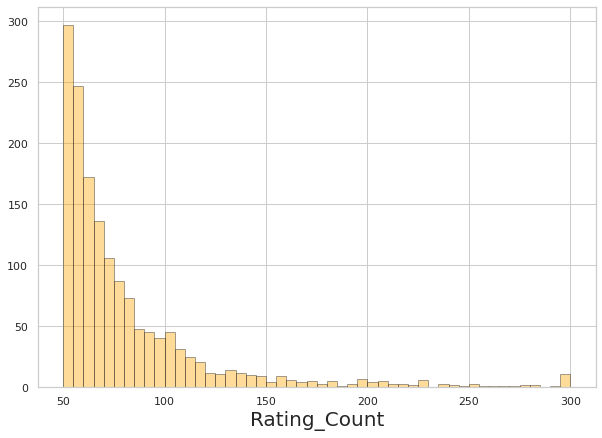

In [26]:
distplot(1, 1, 10, 7, data=rating_users, features=['Rating_Count'], colors=['orange'], kde=False, bins=50)

#### Observations
This is a ratings count distribution grouped by all the Users. For the plot perspective, I have clipped the count limit between 50 to 300 which means any value below 50 or above 300 will be set to the respective values.
As it can been seen from the plot, there are many users which have rated 50 times or below. Ratings count by users gradually decreases which means few users have rated many products.

#### d. Mean Rating - Rating Count Distribution grouped by Products

In [35]:
ratings = pd.DataFrame(electronics_dataframe.groupby('productId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)

In [36]:
ratings['Rating_Count'] = electronics_dataframe.groupby('productId')['Rating'].count()

In [37]:
def scatterplot(rowFeature, colFeature, data):
    f, axes = plt.subplots(1, 1, figsize=(10, 8))
        
    plot=sns.scatterplot(x=rowFeature, y=colFeature, data=data, ax=axes)
    plot.set_xlabel(rowFeature,fontsize=20)
    plot.set_ylabel(colFeature,fontsize=20)            

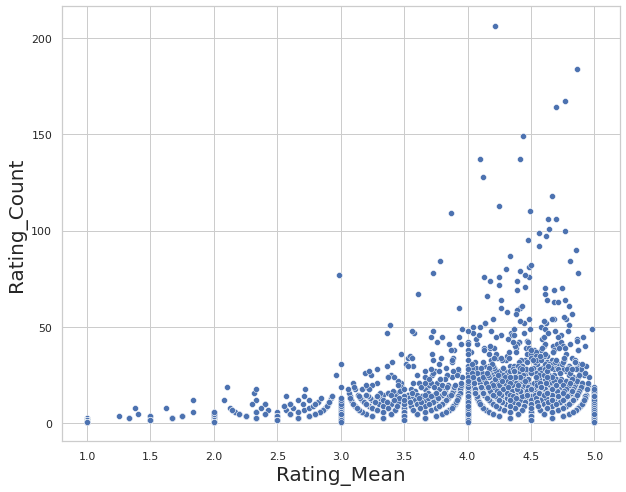

In [38]:
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

#### Observations
This is a joint plot between Mean rating distribution and Rating Count grouped by all the Products. As shown in the plot, data is clustered between mean rating of 3.5 to 5.

#### e. Mean Rating Distribution grouped by Users

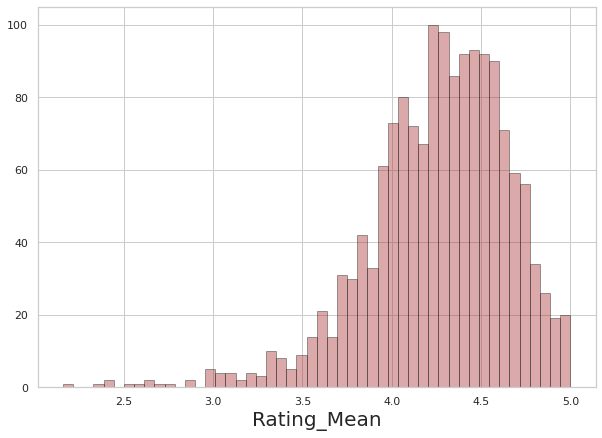

In [39]:
ratings = pd.DataFrame(electronics_dataframe.groupby('userId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

#### Observations
This is a mean rating distribution grouped by all the Users. This looks like slightly left skewed normal distribution.
Data is uniformly distribution from rating 3 to 5 with many around 4 to 4.5. Many users have an average rating of around 4.5.

# Recommender System 

A recommendation engine is a type of data filtering tool using machine learning algorithms to recommend the most relevant items to a particular user or customer. It operates on the principle of finding patterns in consumer behavior data, which can be collected implicitly or explicitly.

Netflix uses a recommendation engine to present viewers with movie and show suggestions. Amazon, on the other hand, uses a recommendation engine to present customers with product recommendations. While each uses one for slightly different purposes, both have the same goal: to drive sales, boost engagement and retention, and deliver more personalized customer experiences.

In the past, recommendations would come from a salesperson or friends and family. Today, we have passed this task in the hands, or minds, of algorithms. As a marketing tool, you could say that these machines are well-trained in the art of up-selling and cross-selling

#### Types of recommendations
There are majorly six types of recommender systems which work primarily in the Media and Entertainment industry:

* Popularity based recommender system
* Collaborative recommender system,
* Content-based recommender system,
* Demographic based recommender system,
* Utility based recommender system,
* Hybrid recommender system.

#### a. Popularity Based Recommender Model
Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt


In [40]:
class popularity_based_recommender_model():
    def __init__(self, train_data, test_data, user_id, item_id):
        self.train_data = train_data
        self.test_data = test_data
        self.user_id = user_id
        self.item_id = item_id
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def fit(self):
        #Get a count of user_ids for each unique product as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
    
        #Sort the products based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(20)

    #Use the popularity based recommender system model to make recommendations
    def recommend(self, user_id, n=5):    
        user_recommendations = self.popularity_recommendations
        
        #Filter products that are not rated by the user
        products_already_rated_by_user = self.train_data[self.train_data[self.user_id] == user_id][self.item_id]        
        user_recommendations = user_recommendations[~user_recommendations[self.item_id].isin(products_already_rated_by_user)]
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols].head(n)     
        self.plot(user_recommendations)
        return user_recommendations
    
    def plot(self, user_recommendations):
        f, axes = plt.subplots(1, 2, figsize=(20, 8))
        cplot1 = sns.barplot(x='Rank', y='score', data=user_recommendations, hue='Rank', ax=axes[0])
        cplot1.set_xlabel('Rank',fontsize=20)
        cplot1.set_ylabel('score',fontsize=20)            
        cplot2 = sns.pointplot(x='Rank', y='score', data=user_recommendations, hue='Rank', ax=axes[1])
        cplot2.set_xlabel('Rank',fontsize=20)
        cplot2.set_ylabel('score',fontsize=20)
        
    def predict_evaluate(self):        
        ratings = pd.DataFrame(self.train_data.groupby(self.item_id)['Rating'].mean())
        
        pred_ratings = [];            
        for data in self.test_data.values:
            if(data[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[data[1]])
            else:
                pred_ratings.append(0)
        
        mse = mean_squared_error(self.test_data['Rating'], pred_ratings)
        rmse = sqrt(mse)
        return rmse


In [43]:
from sklearn.model_selection import train_test_split

In [44]:
train_data, test_data = train_test_split(electronics_dataframe, test_size =.30, random_state=10)
printmd('**Training and Testing Set Distribution**', color='brown')

print(f'Training set has {train_data.shape[0]} rows and {train_data.shape[1]} columns')
print(f'Testing set has {test_data.shape[0]} rows and {test_data.shape[1]} columns')

<span style='color:brown'>**Training and Testing Set Distribution**</span>

Training set has 88109 rows and 3 columns
Testing set has 37762 rows and 3 columns


In [45]:
pr = popularity_based_recommender_model(train_data=train_data, 
                                        test_data=test_data, user_id='userId', 
                                        item_id='productId')

In [46]:
pr.fit()

,user_id,productId,score,Rank
30874,ANTN61S4L7WG9,B0088CJT4U,142,1.0
19570,ANTN61S4L7WG9,B003ES5ZUU,134,2.0
30273,ANTN61S4L7WG9,B007WTAJTO,126,3.0
30557,ANTN61S4L7WG9,B00829THK0,103,6.0
17292,ANTN61S4L7WG9,B002R5AM7C,97,8.0


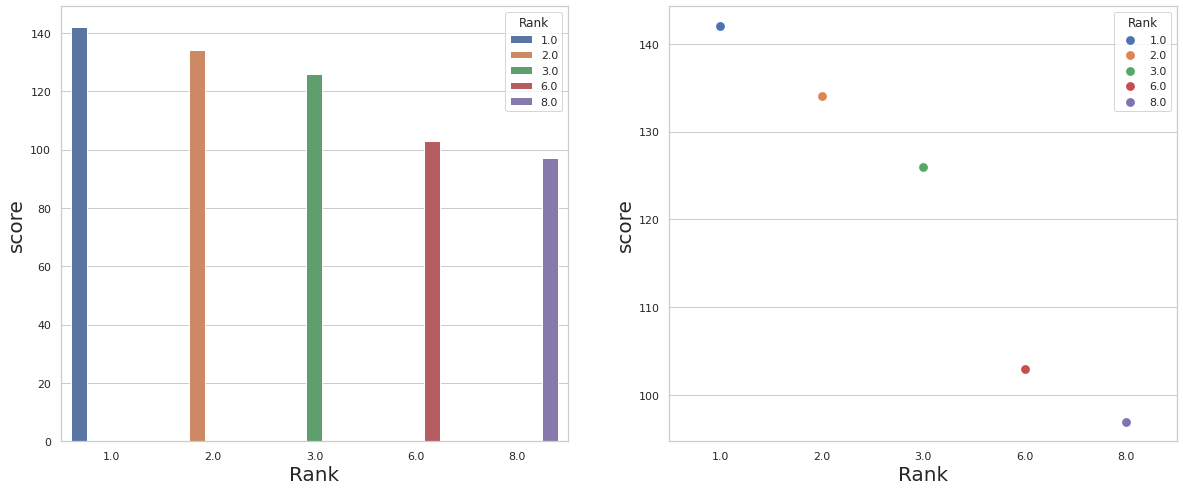

In [47]:
result_pop_user1 = pr.recommend('ANTN61S4L7WG9')
result_pop_user1

,user_id,productId,score,Rank
30874,AYNAH993VDECT,B0088CJT4U,142,1.0
19570,AYNAH993VDECT,B003ES5ZUU,134,2.0
30273,AYNAH993VDECT,B007WTAJTO,126,3.0
8700,AYNAH993VDECT,B000N99BBC,117,4.0
30561,AYNAH993VDECT,B00829TIEK,104,5.0


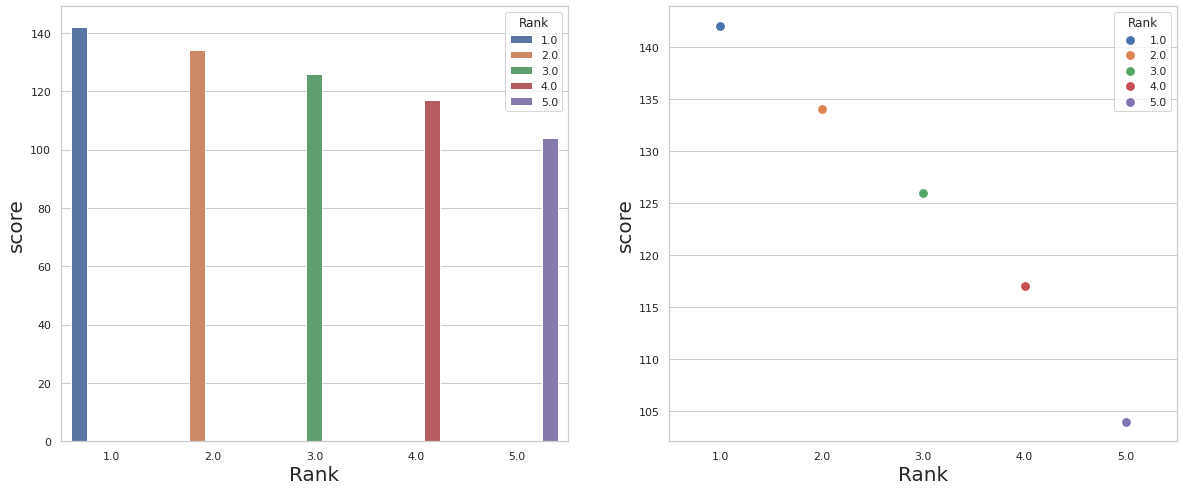

In [48]:
result_pop_user2 = pr.recommend('AYNAH993VDECT')
result_pop_user2


,user_id,productId,score,Rank
30874,A18YMFFJW974QS,B0088CJT4U,142,1.0
19570,A18YMFFJW974QS,B003ES5ZUU,134,2.0
30273,A18YMFFJW974QS,B007WTAJTO,126,3.0
8700,A18YMFFJW974QS,B000N99BBC,117,4.0
30561,A18YMFFJW974QS,B00829TIEK,104,5.0


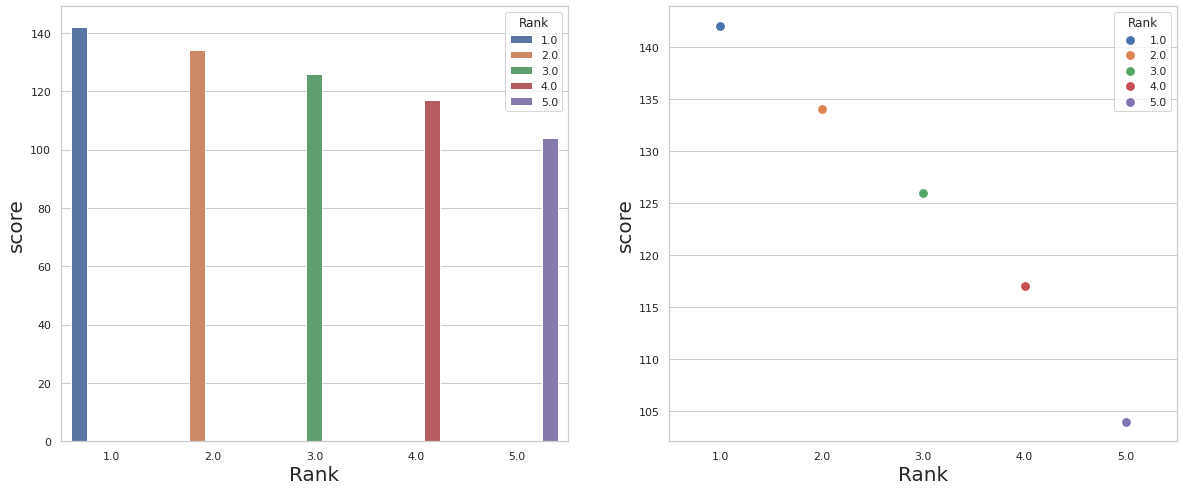

In [56]:
result_pop_user3 = pr.recommend('A18YMFFJW974QS')
result_pop_user3

In [57]:
display_side_by_side([result_pop_user1, result_pop_user2,result_pop_user3])


,user_id,productId,score,Rank
30874,ANTN61S4L7WG9,B0088CJT4U,142,1.0
19570,ANTN61S4L7WG9,B003ES5ZUU,134,2.0
30273,ANTN61S4L7WG9,B007WTAJTO,126,3.0
30557,ANTN61S4L7WG9,B00829THK0,103,6.0
17292,ANTN61S4L7WG9,B002R5AM7C,97,8.0
,user_id,productId,score,Rank
30874,AYNAH993VDECT,B0088CJT4U,142,1.0
19570,AYNAH993VDECT,B003ES5ZUU,134,2.0
30273,AYNAH993VDECT,B007WTAJTO,126,3.0
8700,AYNAH993VDECT,B000N99BBC,117,4.0


In [55]:
pr.predict_evaluate()


2.5098939142231482

#### Observations
Since this is a popularity based recommender model, we are getting same result for all three users i.e. the model is recommending same products for all the users.

### b. Collaborative Filtering Recommender Model using SURPRISE Library
Collaborative filtering is a method of making predictions about the interests of user by analysing the taste of users which are similar to the said user. The idea of filtering patterns by collaborating multiple viewpoints is why it is called collaborative filtering.

In [78]:
reader = Reader()
surprise_data = Dataset.load_from_df(electronics_dataframe, reader)

In [60]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(surprise_data, test_size=.3, random_state=10)

In [61]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [62]:
class collab_filtering_based_recommender_model():
    def __init__(self, model, trainset, testset, data):
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.data = data
        self.pred_test = None
        self.recommendations = None
        self.top_n = None
        self.recommenddf = None

    def fit_and_predict(self):        
        printmd('**Fitting the train data...**', color='brown')
        self.model.fit(self.trainset)       

        printmd('**Predicting the test data...**', color='brown')
        self.pred_test = self.model.test(self.testset)        
        rmse = round(accuracy.rmse(self.pred_test), 3)
        printmd('**RMSE for the predicted result is ' + str(rmse) + '**', color='brown')   
        
        self.top_n = get_top_n(self.pred_test)
        self.recommenddf = pd.DataFrame(columns=['userId', 'productId', 'Rating'])
        for item in self.top_n:
            subdf = pd.DataFrame(self.top_n[item], columns=['productId', 'Rating'])
            subdf['userId'] = item
            cols = subdf.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            subdf = subdf[cols]        
            self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)        
        return rmse
        
    def cross_validate(self):
        printmd('**Cross Validating the data...**', color='brown')
        cv_result = cross_validate(self.model, self.data, n_jobs=-1)
        cv_result = round(cv_result['test_rmse'].mean(),3)
        printmd('**Mean CV RMSE is ' + str(cv_result)  + '**', color='brown')
        return cv_result

    def recommend(self, user_id, n=5):
        printmd('**Recommending top ' + str(n)+ ' products for userid : ' + user_id + ' ...**', color='brown')
        df = self.recommenddf[self.recommenddf['userId'] == user_id].head(n)
        display(df)
        return df

In [63]:
from surprise.model_selection import RandomizedSearchCV

def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

### KNN With Means - Memory Based Collaborative Filtering

#### User-User Collaborative Filtering

To find the rating R that a user U would give to an item I, the approach includes:

Finding users similar to U who have rated the item I
Calculating the rating R based the ratings of users found in the previous step
Here we are using KNN with means to remove the bias by taking into account the mean ratings of each user.

#### Find optimal model using RandomizedSearchCV

In [64]:
sim_options = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [True],
}
params = { 'k': range(30,50,1), 'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_data)

{'rmse': 1.034456050638283}
{'rmse': {'k': 39, 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': True}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fad4e6446d0>}


#### Initialized the model

In [65]:
knnwithmeans = clf.best_estimator['rmse']
col_fil_knnwithmeans = collab_filtering_based_recommender_model(knnwithmeans, trainset, testset, surprise_data)

#### Fit and Predict

In [66]:
knnwithmeans_rmse = col_fil_knnwithmeans.fit_and_predict()

<span style='color:brown'>**Fitting the train data...**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.


<span style='color:brown'>**Predicting the test data...**</span>

RMSE: 1.0417


<span style='color:brown'>**RMSE for the predicted result is 1.042**</span>

#### Cross Validate the model

In [67]:
knnwithmeans_cv_rmse = col_fil_knnwithmeans.cross_validate()


<span style='color:brown'>**Cross Validating the data...**</span>

<span style='color:brown'>**Mean CV RMSE is 1.036**</span>

#### Test the model

In [68]:
result_knn_user1 = col_fil_knnwithmeans.recommend(user_id='ANTN61S4L7WG9', n=5)
result_knn_user2 = col_fil_knnwithmeans.recommend(user_id='AYNAH993VDECT', n=5)
result_knn_user3 = col_fil_knnwithmeans.recommend(user_id='A18YMFFJW974QS', n=5)

<span style='color:brown'>**Recommending top 5 products for userid : ANTN61S4L7WG9 ...**</span>

,userId,productId,Rating
0,ANTN61S4L7WG9,B009Z7KMUM,5.0
1,ANTN61S4L7WG9,B004CLYEDC,5.0
2,ANTN61S4L7WG9,B0099SMFVQ,4.750906
3,ANTN61S4L7WG9,B00FRMAOIO,4.629167
4,ANTN61S4L7WG9,B0097CXWUW,4.502918


<span style='color:brown'>**Recommending top 5 products for userid : AYNAH993VDECT ...**</span>

,userId,productId,Rating
0,AYNAH993VDECT,B00CPIF4G0,4.265306
1,AYNAH993VDECT,B002FU6KF2,4.265306
2,AYNAH993VDECT,B005NHTG6O,4.265306
3,AYNAH993VDECT,B005G0CUP2,4.265306
4,AYNAH993VDECT,B0038KN114,4.265306


<span style='color:brown'>**Recommending top 5 products for userid : A18YMFFJW974QS ...**</span>

,userId,productId,Rating
0,A18YMFFJW974QS,B001PA94TW,4.261789
1,A18YMFFJW974QS,B001NZUFN8,4.261789
2,A18YMFFJW974QS,B0007WWI2O,4.261789
3,A18YMFFJW974QS,B003QP41EC,4.261789
4,A18YMFFJW974QS,B002RM08RE,4.15625


#### Observations
KNN (K-Nearest Neighbours) With Means model has an test RMSE value of 1.04 and cross validation RMSE value of 1.037.

AS for the recommendations, each user will have different products recommended to them as they are infered based on the ratings provided by the similar users. To find the similar users, KNN model uses cosine similarity or Pearson's correlation to find the nerghbours.

### SVD - Model Based Collaborative Filtering
The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler. It provides another way to factorize a matrix, into singular vectors and singular values.

A=U.Sigma.VT

#### Find optimal model using RandomizedSearchCV

In [69]:
params= {
    "n_epochs": [5, 10, 15, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
clf = find_best_model(SVD, params, surprise_data)

{'rmse': 0.9809014201818418}
{'rmse': {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}}
{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fad32771160>}


#### Intialized the model

In [70]:
svd = clf.best_estimator['rmse']
col_fil_svd = collab_filtering_based_recommender_model(svd, trainset, testset, surprise_data)


#### Fit and Predict

In [71]:
svd_rmse = col_fil_svd.fit_and_predict()

<span style='color:brown'>**Fitting the train data...**</span>

<span style='color:brown'>**Predicting the test data...**</span>

RMSE: 0.9902


<span style='color:brown'>**RMSE for the predicted result is 0.99**</span>

#### Cross Validate the model

In [72]:
svd_cv_rmse = col_fil_svd.cross_validate()

<span style='color:brown'>**Cross Validating the data...**</span>

<span style='color:brown'>**Mean CV RMSE is 0.981**</span>

#### Test the model

In [73]:
result_svd_user1 = col_fil_svd.recommend(user_id='ANTN61S4L7WG9', n=5)
result_svd_user2 = col_fil_svd.recommend(user_id='AYNAH993VDECT', n=5)
result_svd_user3 = col_fil_svd.recommend(user_id='A18YMFFJW974QS', n=5)

<span style='color:brown'>**Recommending top 5 products for userid : ANTN61S4L7WG9 ...**</span>

,userId,productId,Rating
0,ANTN61S4L7WG9,B0099SMFVQ,4.632831
1,ANTN61S4L7WG9,B004CLYEDC,4.554172
2,ANTN61S4L7WG9,B00HHRP11C,4.535256
3,ANTN61S4L7WG9,B00HVT27B8,4.50015
4,ANTN61S4L7WG9,B00E87E1OM,4.445674


<span style='color:brown'>**Recommending top 5 products for userid : AYNAH993VDECT ...**</span>

,userId,productId,Rating
0,AYNAH993VDECT,B006ZT4VA0,4.608708
1,AYNAH993VDECT,B003ZKG10K,4.582078
2,AYNAH993VDECT,B008LCYIEI,4.511767
3,AYNAH993VDECT,B00IVPU59W,4.474641
4,AYNAH993VDECT,B00475K64E,4.458573


<span style='color:brown'>**Recommending top 5 products for userid : A18YMFFJW974QS ...**</span>

,userId,productId,Rating
0,A18YMFFJW974QS,B00BOHNYU6,4.597064
1,A18YMFFJW974QS,B001MXLD4G,4.496877
2,A18YMFFJW974QS,B000TKHGL2,4.454328
3,A18YMFFJW974QS,B002RM08RE,4.4109
4,A18YMFFJW974QS,B006ZZUK5Y,4.34372


#### Observations
SVD (Singular Value Decomposition) model has an test RMSE value of 0.99 and cross validation RMSE value of 0.981. Using this model we have a reduced RMSE value compared to KNNWithMeans.

AS for the recommendations, each user will have different products recommended to them as they are infered by filling out missing entries in the matrix during matrix factorization using SVD.

## Conclusion

Recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy or anything else depending on industries). Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors.

We have used 2 different types here,

* Popularity Based Recommender System
* Collaborative Filtering Recommender System
Below are the recommended results of same 3 users picked at random for all the models

#### Popularity Based Recommendation Model
Being popularity based recommender model, we have got the same result for all three users i.e. the model is recommending same products for all the users as shown below:

In [74]:
display_side_by_side([result_pop_user1, result_pop_user2, result_pop_user3])

,user_id,productId,score,Rank
30874,ANTN61S4L7WG9,B0088CJT4U,142,1.0
19570,ANTN61S4L7WG9,B003ES5ZUU,134,2.0
30273,ANTN61S4L7WG9,B007WTAJTO,126,3.0
30557,ANTN61S4L7WG9,B00829THK0,103,6.0
17292,ANTN61S4L7WG9,B002R5AM7C,97,8.0
,user_id,productId,score,Rank
30874,AYNAH993VDECT,B0088CJT4U,142,1.0
19570,AYNAH993VDECT,B003ES5ZUU,134,2.0
30273,AYNAH993VDECT,B007WTAJTO,126,3.0
8700,AYNAH993VDECT,B000N99BBC,117,4.0


### Collaborative Filtering Recommendation Model

#### KNNWithMeans Model
KNN (K-Nearest Neighbours) With Means model has an test RMSE value of 1.04 and cross validation RMSE value of 1.037. Each user will have different products recommended to them as they are infered based on the ratings provided by the similar users.

In [75]:
display_side_by_side([result_knn_user1, result_knn_user2, result_knn_user3])


,userId,productId,Rating
0,ANTN61S4L7WG9,B009Z7KMUM,5.0
1,ANTN61S4L7WG9,B004CLYEDC,5.0
2,ANTN61S4L7WG9,B0099SMFVQ,4.750906
3,ANTN61S4L7WG9,B00FRMAOIO,4.629167
4,ANTN61S4L7WG9,B0097CXWUW,4.502918
,userId,productId,Rating
0,AYNAH993VDECT,B00CPIF4G0,4.265306
1,AYNAH993VDECT,B002FU6KF2,4.265306
2,AYNAH993VDECT,B005NHTG6O,4.265306
3,AYNAH993VDECT,B005G0CUP2,4.265306


### SVD Model
SVD (Singular Value Decomposition) model has an test RMSE value of 0.99 and cross validation RMSE value of 0.981. Each user will have different products recommended to them.

In [76]:
display_side_by_side([result_svd_user1, result_svd_user2, result_svd_user3])

,userId,productId,Rating
0,ANTN61S4L7WG9,B0099SMFVQ,4.632831
1,ANTN61S4L7WG9,B004CLYEDC,4.554172
2,ANTN61S4L7WG9,B00HHRP11C,4.535256
3,ANTN61S4L7WG9,B00HVT27B8,4.50015
4,ANTN61S4L7WG9,B00E87E1OM,4.445674
,userId,productId,Rating
0,AYNAH993VDECT,B006ZT4VA0,4.608708
1,AYNAH993VDECT,B003ZKG10K,4.582078
2,AYNAH993VDECT,B008LCYIEI,4.511767
3,AYNAH993VDECT,B00IVPU59W,4.474641


#### 
SVD is better model compared to KNN or Popularity with a better RMSE value of 0.981. We can also see the products that are recommended in SVD is different to that of KNNWithMeans as SVD uses matrix factorization. This is more useful when the data is sparse with many missing ratings.